## Dataset Overview
HAM10000 ("Human Against Machine with 10000 training images") dataset - a large collection of multi-source dermatoscopic images of pigmented lesions

The dermatoscopic images are collected from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images.

It has 7 different classes of skin cancer which are listed below :
- Melanocytic nevi
- Melanoma
- Benign keratosis-like lesions
- Basal cell carcinoma
- Actinic keratoses
- Vascular lesions
- Dermatofibroma 

## Importing libraries

In [93]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,KFold

import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Activation, BatchNormalization
from sklearn.metrics import classification_report, accuracy_score


## Reading the Data

In [94]:
data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


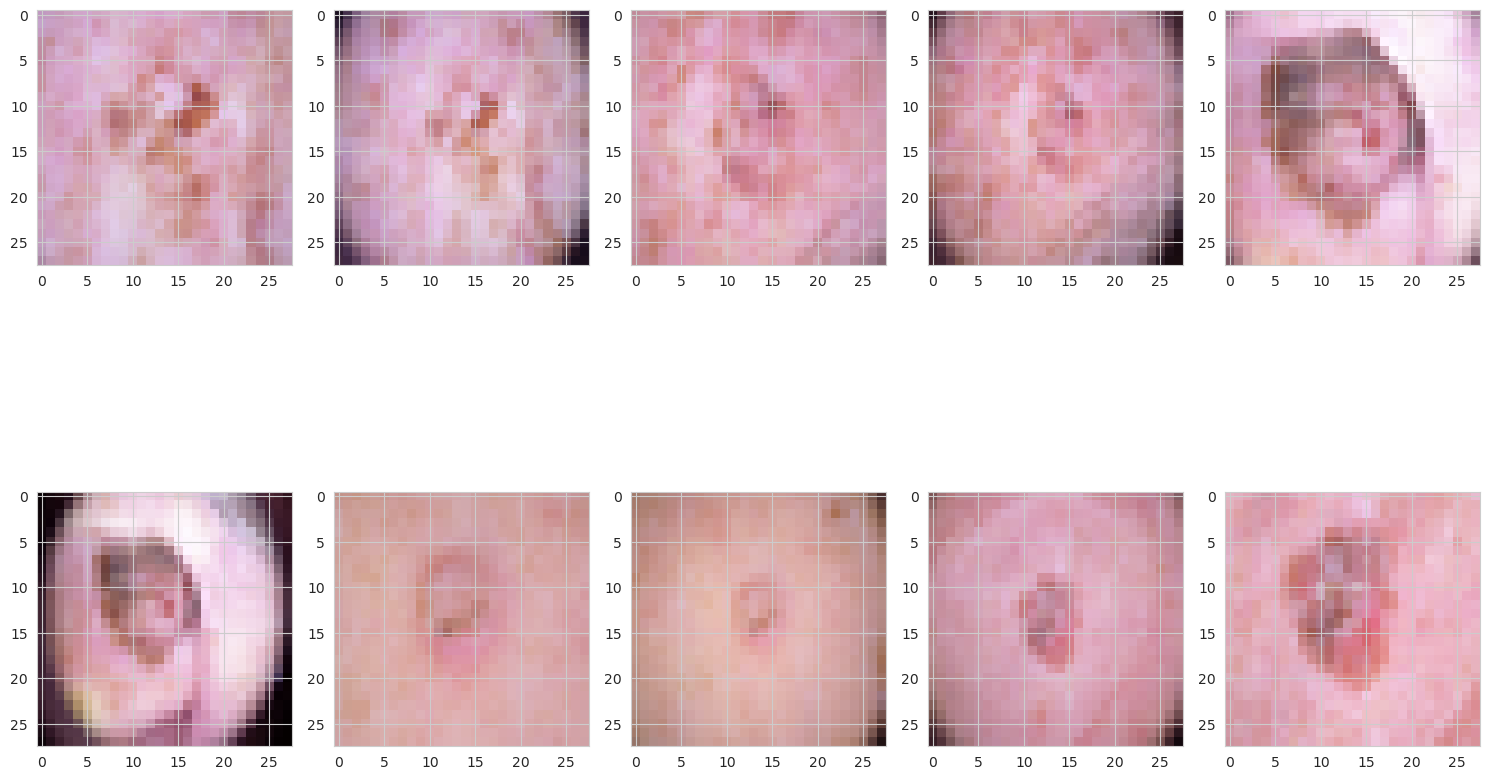

In [95]:
f , ax = plt.subplots(2,5)
f.set_size_inches(15, 15)
k = 0
y1 = data['label']
x1 = data.drop(columns = ['label'])
x1= np.array(x1).reshape(-1,28,28,3)
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x1[k].reshape(28,28,3))
#         ax[i, j].set_title(f"Image {Y_train[4]}")
        k = k + 1
    plt.tight_layout()

## Data Preprocessing
## Data Cleaning

In [96]:
data['label'].unique()
y = data['label']
x = data.drop(columns = ['label'])
data.isnull().sum().sum() #no null values present

0

In [97]:
meta_data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
meta_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [98]:
meta_data['dx'].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [99]:
data.isnull().sum().sum() #no null values present
meta_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


## Exploratory Data Analysis

Text(0.5, 1.0, 'Frequency Distribution of Classes')

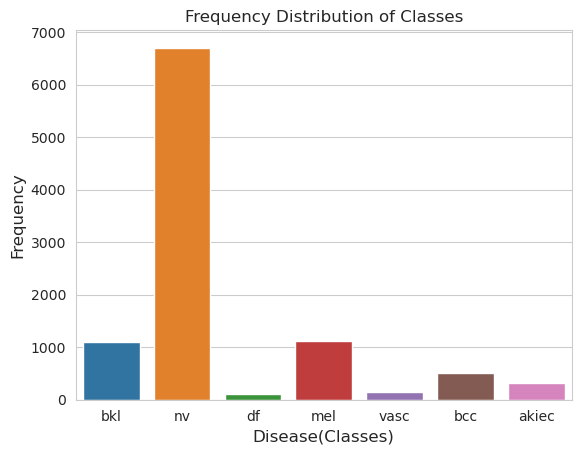

In [100]:
sns.countplot(x = 'dx', data = meta_data)
plt.xlabel('Disease(Classes)', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes')

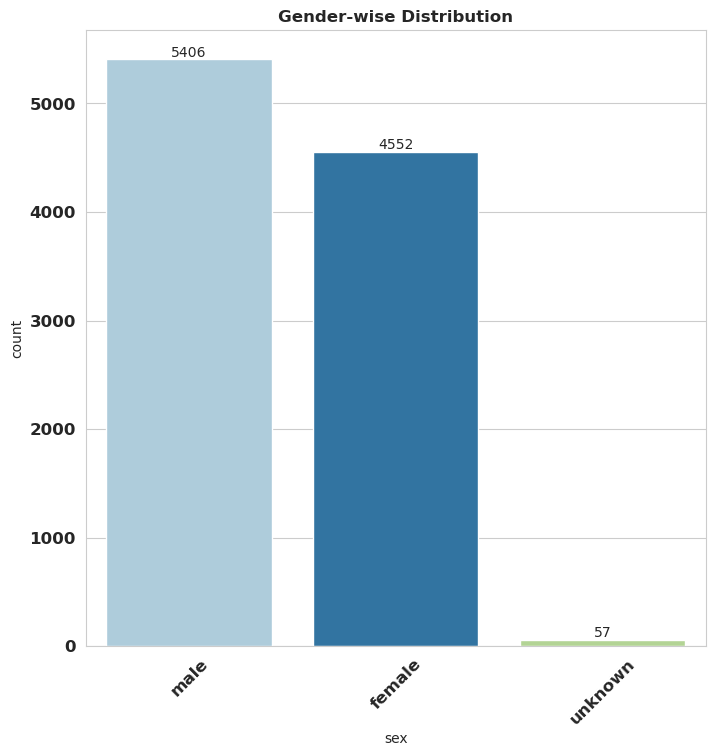

In [101]:
sns.set_style('whitegrid')
colors = ['#87ace8','#e3784d', 'green']
fig,axes = plt.subplots(figsize=(8,8))

ax = sns.countplot(x='sex',data=meta_data, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Gender-wise Distribution',fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.show()

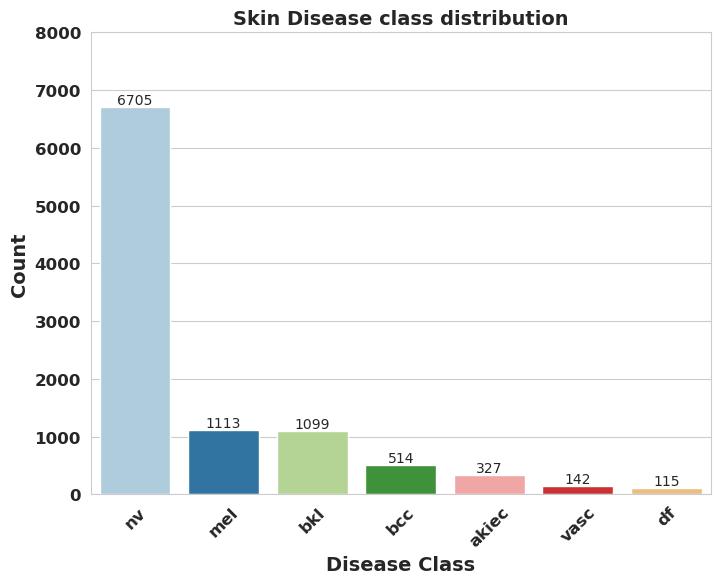

In [102]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(8,6))
ax = sns.countplot(x='dx',data=meta_data, order = meta_data['dx'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Skin Disease class distribution',fontweight='bold',fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, 8000)
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel("Count",fontweight='bold', fontsize=14)
plt.xlabel("Disease Class", fontweight='bold', fontsize=14)
plt.show()

In [103]:
classes = {2:'bkl', 4:'nv', 3:'df', 6:'mel', 5:'vasc', 1:'bcc', 0:'akiec'}

classes_labels=[]
for key in classes.keys():
    classes_labels.append(key)
print(classes_labels)

[2, 4, 3, 6, 5, 1, 0]


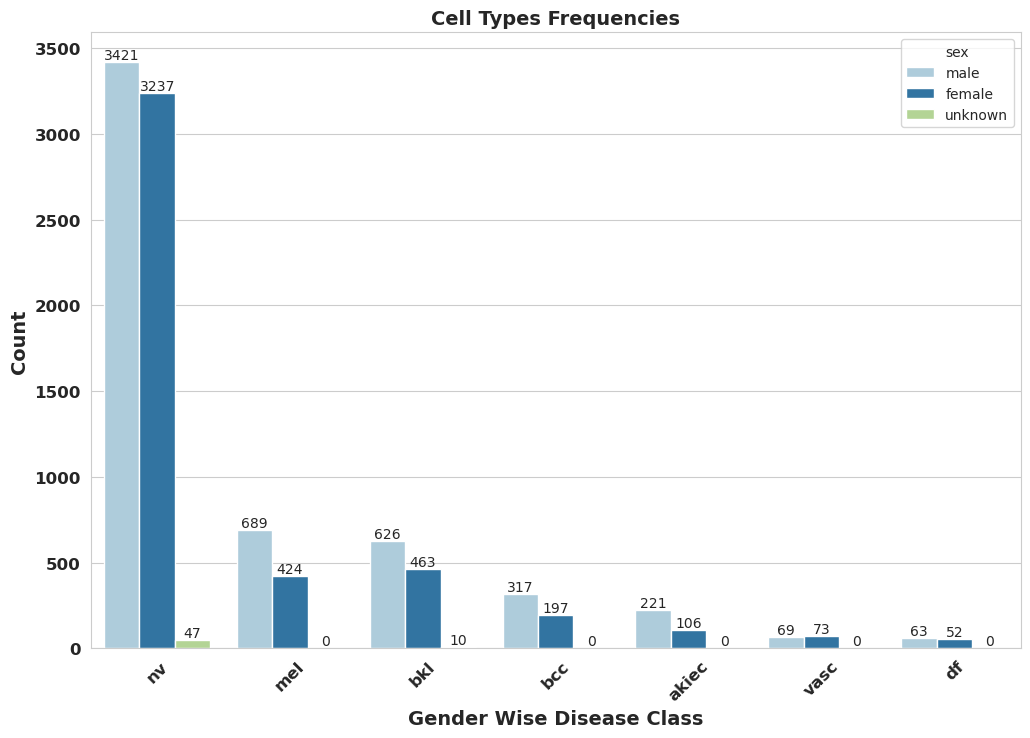

In [104]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx',hue='sex', data=meta_data, order = meta_data['dx'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Frequencies',fontweight='bold', fontsize=14)
plt.xticks(rotation=45)
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel("Count",fontweight='bold', fontsize=14)
plt.xlabel("Gender Wise Disease Class", fontweight='bold', fontsize=14)
plt.show()

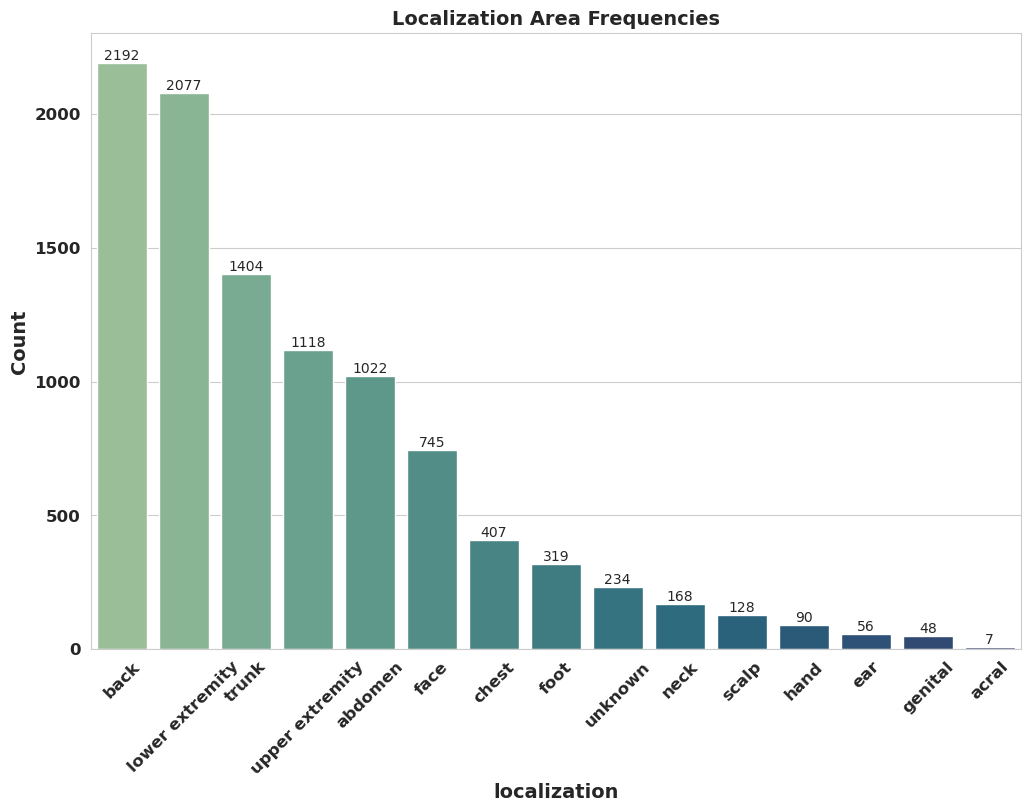

In [105]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='localization',data=meta_data, order = meta_data['localization'].value_counts().index, palette = 'crest')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Localization Area Frequencies',fontweight='bold', fontsize=14)
plt.xticks(rotation=45)
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel("Count",fontweight='bold', fontsize=14)
plt.xlabel("localization", fontweight='bold', fontsize=14)
plt.show()

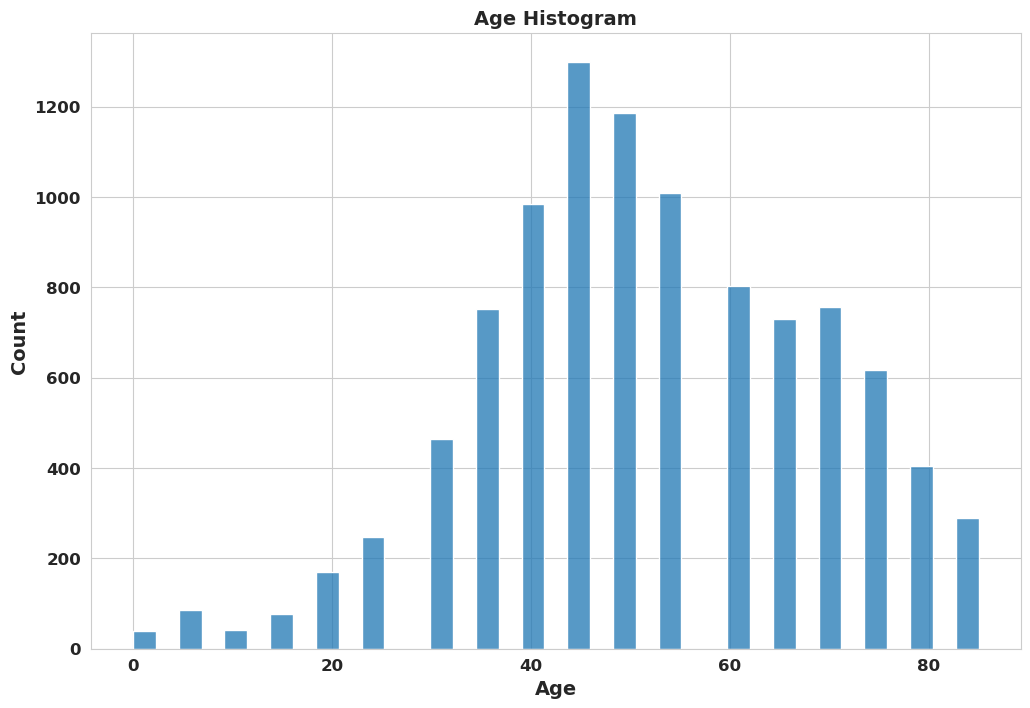

In [106]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=meta_data, x='age')
plt.title('Age Histogram',fontweight='bold', fontsize=14)
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel("Count",fontweight='bold', fontsize=14)
plt.xlabel("Age", fontweight='bold', fontsize=14)
plt.show()

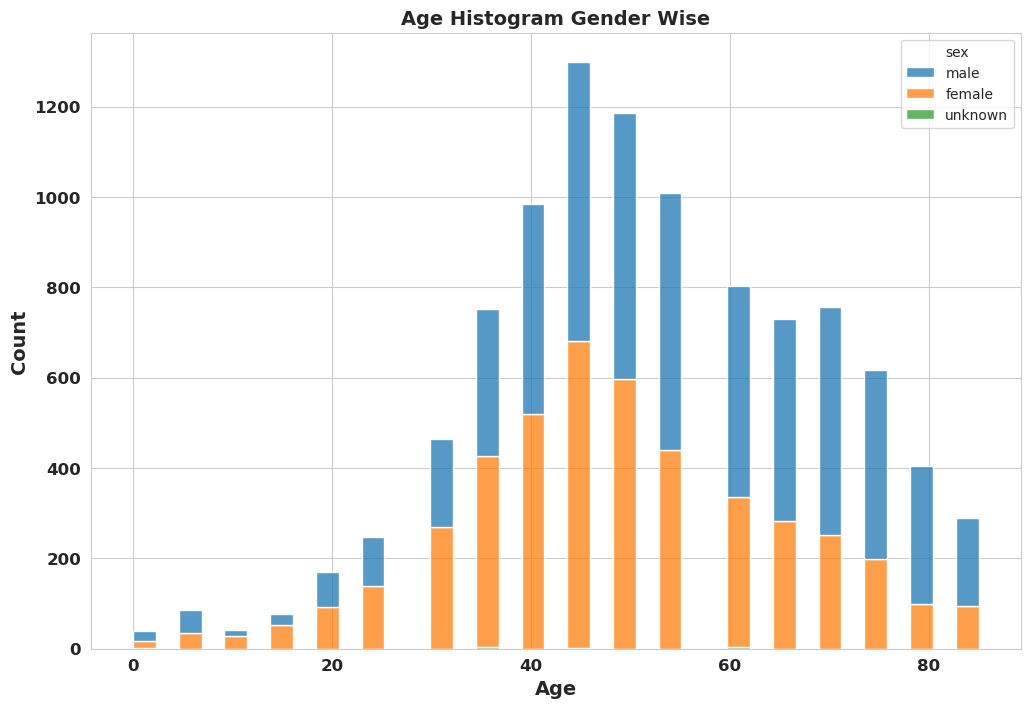

In [107]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=meta_data, x='age',hue='sex',multiple='stack')
plt.title('Age Histogram Gender Wise',fontweight='bold', fontsize=14)
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel("Count",fontweight='bold', fontsize=14)
plt.xlabel("Age", fontweight='bold', fontsize=14)
plt.show()

In [108]:
print(x.shape,y.shape)

(10015, 2352) (10015,)


In [121]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(8012, 2352) (8012,)
(2003, 2352) (2003,)


In [122]:
import numpy as np
from imblearn.over_sampling import ADASYN

# Assuming you have your feature data 'X' and corresponding labels 'y'
# X: numpy array of shape (n_samples, n_features)
# y: numpy array of shape (n_samples,)

# Instantiate the ADASYN oversampler
adasyn = ADASYN(random_state=42)

# Resample the data using ADASYN
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

# Check the class distribution after resampling
unique, counts = np.unique(y_resampled, return_counts=True)
print(dict(zip(unique, counts)))

{0: 5326, 1: 5375, 2: 5516, 3: 5348, 4: 5367, 5: 5376, 6: 5431}


In [123]:
print(x.shape)
print(y.shape)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
print(X_resampled.shape)
print(y_resampled.shape)

(10015, 2352)
(10015,)
(8012, 2352) (8012,)
(2003, 2352) (2003,)
(37739, 2352)
(37739,)


In [73]:
# Split the dataset into training and testing sets
# Split the dataset into training and testing sets




(8012, 2352) (8012,)
(2003, 2352) (2003,)


In [124]:
# reshaping the data so that it can be taken by convolution neural network(without disturbing the no. of samples)
X_resampled= np.array(X_resampled).reshape(-1,28,28,3)
print('Shape of X :',X_resampled.shape)
print('Shape of y :',y_resampled.shape)

Shape of X : (37739, 28, 28, 3)
Shape of y : (37739,)


In [125]:
print(y_resampled)

0        4
1        4
2        4
3        2
4        2
        ..
37734    6
37735    6
37736    6
37737    6
37738    6
Name: label, Length: 37739, dtype: int64


In [126]:
newLabel = []

for i in range(len(y_resampled)):
    for key in classes.keys():
        if y_resampled[i] == key:
            newLabel.append(classes[key])



In [127]:
classes = {4:'melanocytic nevi',
6: 'melanoma',
2:'benign keratosis-like lesions',
1:'basal cell carcinoma',
5:'pyogenic granulomas and hemorrhage',
0:'Actinic keratoses and intraepithelial carcinomae',
3:'dermatofibroma'}


In [128]:
y_resampled[:10]

0    4
1    4
2    4
3    2
4    2
5    4
6    4
7    2
8    0
9    4
Name: label, dtype: int64

In [129]:
l_train = np.array(y_resampled)
l_train[1]

4

In [130]:
model_CNN = Sequential()
model_CNN.add(Conv2D(32, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model_CNN.add(BatchNormalization())


model_CNN.add(MaxPool2D(pool_size = (2,2)))


model_CNN.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model_CNN.add(BatchNormalization())

model_CNN.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
model_CNN.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model_CNN.add(BatchNormalization())

model_CNN.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

model_CNN.add(Flatten())


model_CNN.add(Dense(64, activation = 'relu'))
model_CNN.add(BatchNormalization())


model_CNN.add(Dense(32))
model_CNN.add(Activation(activation='relu'))
model_CNN.add(BatchNormalization())

model_CNN.add(Dense(16))
model_CNN.add(Activation(activation='relu'))
model_CNN.add(BatchNormalization())

model_CNN.add(Dense(7))
model_CNN.add(Activation(activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model_CNN.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
print(model_CNN.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_7 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                      

In [131]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto')
history = model_CNN.fit(X_resampled,
                    y_resampled,
                    validation_split=0.2,
                    batch_size = 64,
                    epochs = 100,
                    callbacks=[reduce_lr,early_stop])

Epoch 1/100
472/472 [==============================] - 9s 10ms/step - loss: 0.7770 - accuracy: 0.7471 - val_loss: 1.3298 - val_accuracy: 0.4079 - lr: 0.0010
Epoch 2/100
472/472 [==============================] - 5s 10ms/step - loss: 0.3012 - accuracy: 0.9013 - val_loss: 1.8210 - val_accuracy: 0.3050 - lr: 0.0010
Epoch 3/100
472/472 [==============================] - 4s 9ms/step - loss: 0.2112 - accuracy: 0.9280 - val_loss: 2.0271 - val_accuracy: 0.3541 - lr: 0.0010
Epoch 4/100
466/472 [============================>.] - ETA: 0s - loss: 0.1698 - accuracy: 0.9418
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
472/472 [==============================] - 4s 9ms/step - loss: 0.1698 - accuracy: 0.9418 - val_loss: 1.9949 - val_accuracy: 0.3088 - lr: 0.0010
Epoch 5/100
472/472 [==============================] - 4s 8ms/step - loss: 0.1053 - accuracy: 0.9647 - val_loss: 0.9943 - val_accuracy: 0.5543 - lr: 1.0000e-04
Epoch 6/100
472/472 [==============================]

In [132]:
X_test = np.array(X_test).reshape(-1,28,28,3)


In [133]:
results = model_CNN.evaluate(X_test , y_test, verbose=0)

print("CNN Model Test Results")
print("        Test Loss: {:.5f}".format(results[0]))
print("    Test Accuracy: {:.2f}%".format(results[1] * 100))

CNN Model Test Results
        Test Loss: 1.15323
    Test Accuracy: 74.69%


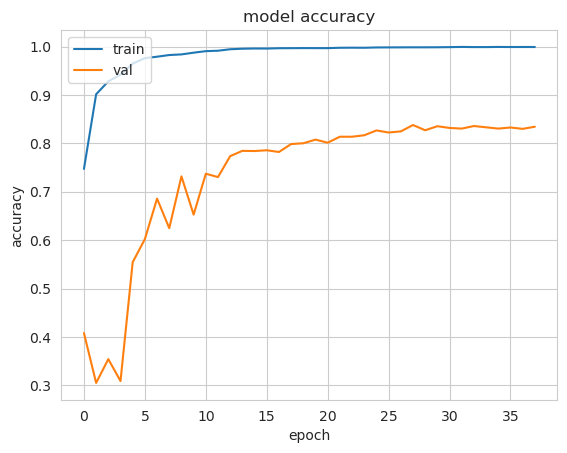

In [134]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

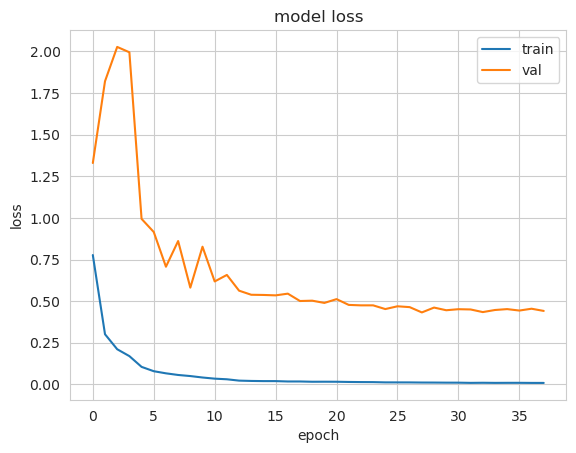

In [135]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [136]:
from sklearn.metrics import confusion_matrix , classification_report

y_true_CNN = list(y_test)
y_pred_CNN = model_CNN.predict(X_test)
y_pred_CNN = list(map(lambda x: np.argmax(x), y_pred_CNN))
print("Predicting First Ten Rows:")
print('Y Actual Values :' , y_true_CNN[0:10])
print('Y Predicted Values :' , y_pred_CNN[0:10])

63/63 [==============================] - 0s 2ms/step
Predicting First Ten Rows:
Y Actual Values : [6, 4, 6, 2, 4, 4, 4, 4, 6, 4]
Y Predicted Values : [2, 4, 0, 4, 4, 4, 2, 4, 2, 4]


[[ 101   75    0   28    1    9   14]
 [  45 1211    0   62    5   12    3]
 [   6    8    4    0    1    8    1]
 [  25   91    1   90    1    8   10]
 [   2    2    0    3   14    0    0]
 [   8    9    0    7    3   60    6]
 [   8   23    0   12    0   10   16]]


<Axes: >

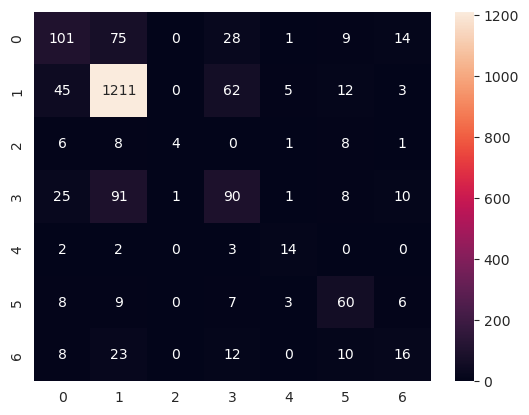

In [137]:
cm_CNN = confusion_matrix(y_true_CNN,y_pred_CNN,labels=classes_labels)
print(confusion_matrix(y_true_CNN,y_pred_CNN,labels=classes_labels))
sns.heatmap(cm_CNN, annot = True, fmt='')

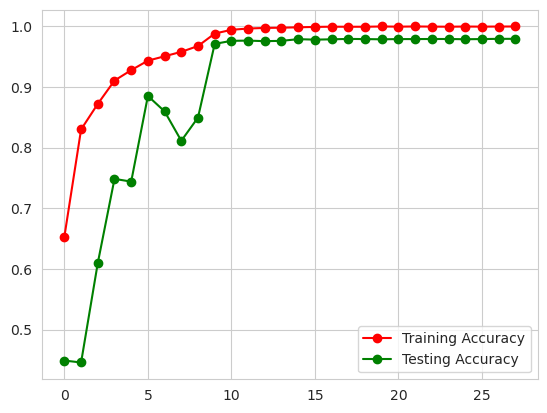

In [91]:
#training acc vs testing acc graph
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

In [92]:
#predicting
y_pred_CNN  = model_CNN.predict(X_test)
target_names = [f"{classes[i]}" for i in range(7)]
y_pred_CNN = list(map(lambda x: np.argmax(x), y_pred_CNN))
print("CNN Model Prediction Results")
print(classification_report(y_test , y_pred_CNN,target_names=target_names))

295/295 [==============================] - 1s 2ms/step
CNN Model Prediction Results
                                                  precision    recall  f1-score   support

Actinic keratoses and intraepithelial carcinomae       0.99      1.00      1.00      1313
                            basal cell carcinoma       0.98      1.00      0.99      1314
                   benign keratosis-like lesions       0.95      0.98      0.96      1389
                                  dermatofibroma       1.00      1.00      1.00      1357
                                melanocytic nevi       0.98      0.87      0.92      1356
              pyogenic granulomas and hemorrhage       0.99      1.00      1.00      1303
                                        melanoma       0.94      0.98      0.96      1406

                                        accuracy                           0.97      9438
                                       macro avg       0.98      0.98      0.97      9438
              